In [2]:
import os

import openai
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]


client = OpenAI()

file = client.files.create(
    file=open("parking_violation.csv", "rb"), purpose="assistants"
)

assistant = client.beta.assistants.create(
    name="Data visualizer",
    description="You are great at creating beautiful data visualizations. You analyze data present in .csv files, understand trends, and come up with data visualizations relevant to those trends. You also share a brief text summary of the trends observed.",
    model="gpt-4o",
    tools=[{"type": "code_interpreter"}],
    tool_resources={"code_interpreter": {"file_ids": [file.id]}},
)

thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Create 3 data visualizations based on the trends in this file.",
            "attachments": [
                {"file_id": file.id, "tools": [{"type": "code_interpreter"}]}
            ],
        }
    ]
)

# Submit the thread to the assistant (as a new run).
run = client.beta.threads.runs.create(thread_id=thread.id, assistant_id=assistant.id)
print(f"👉 Run Created: {run.id}")


In [8]:
import time

# Wait for run to complete.
while run.status != "completed":
    run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
    print(f"🏃 Run Status: {run.status}")
    time.sleep(1)
else:
    print(f"🏁 Run Completed!")


🏁 Run Completed!


In [50]:
# Get the latest message from the thread.
message_response = client.beta.threads.messages.list(thread_id=thread.id)
message_response.data[0]

Message(id='msg_4eAG4WDmko95o5K2jR5HvEjH', assistant_id='asst_PVcQX7FjZVjaFF2NHJsfTy31', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-yxDf3NDSodEzxxzooqUa9J2a', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[], value='The third visualization shows the top 10 most common violation codes. Violation code 98 appears most frequently, followed by codes 40 and 14.\n\nTo summarize, we visualized:\n1. The trend of violations over time, showing a spike around 2019.\n2. The distribution of vehicle makes with the most violations, where Honda, Nissan, and Toyota dominate.\n3. The distribution of the top 10 violation codes, with code 98 being the most common.\n\nIf you need further analysis or more specific insights, please let me know!'), type='text')], created_at=1718007592, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_i9fsKMwEiX5YvZFRLmVS8l2H', sta

In [51]:
from openai import OpenAI

client = OpenAI()

image_data = client.files.content(message_response.data[0].content[0].image_file.file_id)
image_data_bytes = image_data.read()

with open("my-image.png", "wb") as file:
    file.write(image_data_bytes)

In [55]:
pip install Pillow numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 1.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


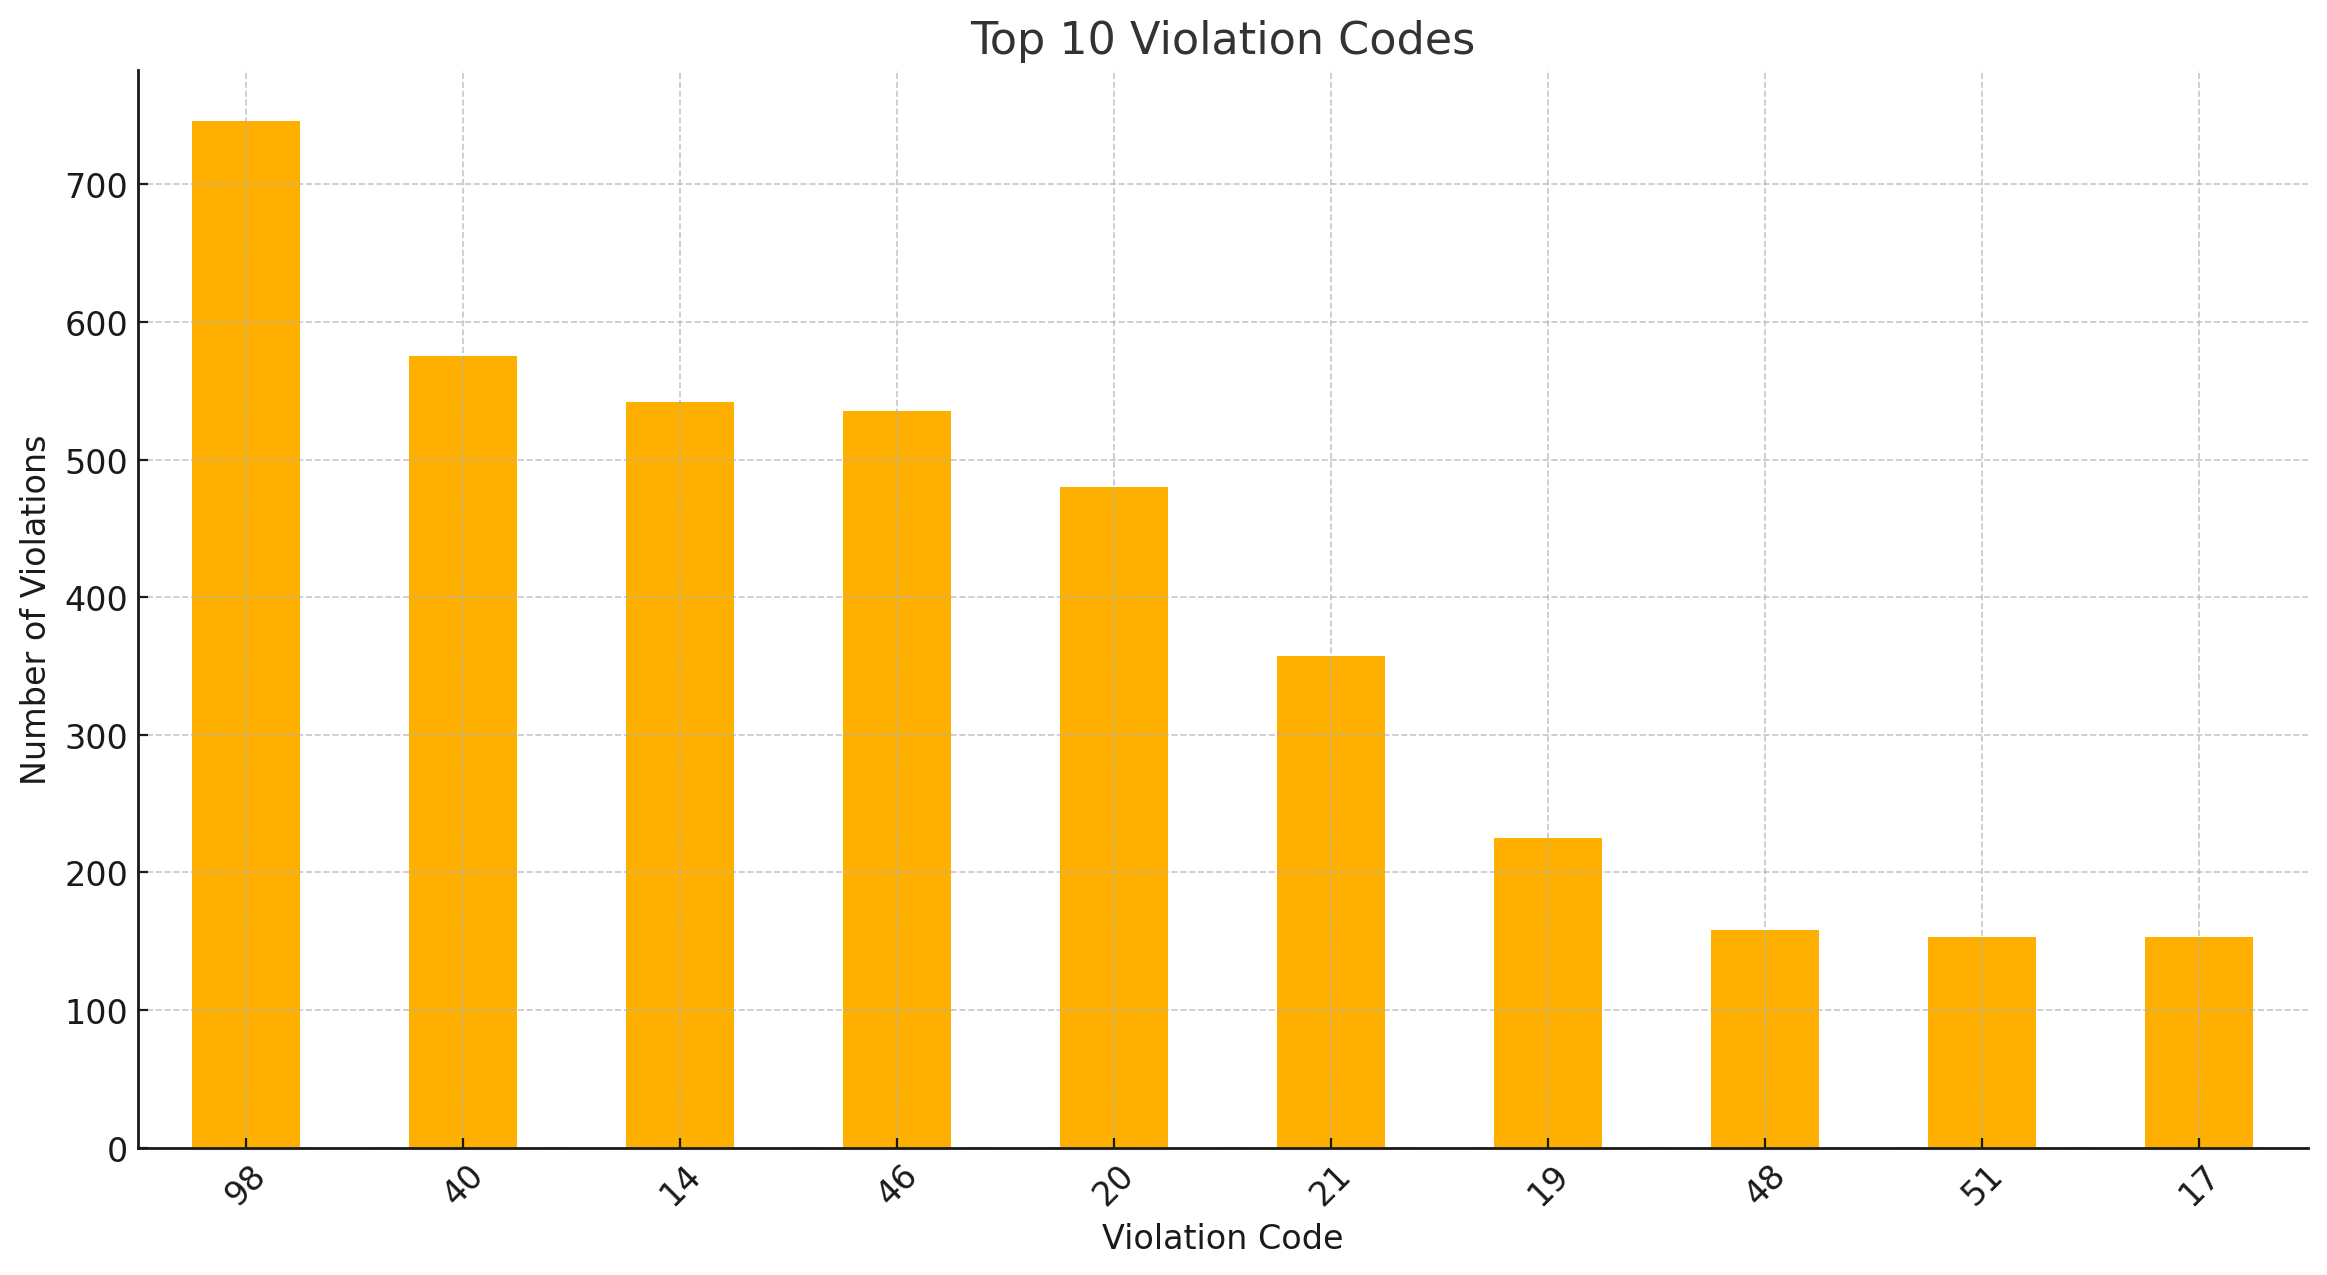

PNG (2327, 1275) RGBA


In [56]:
from PIL import Image

# Open an image file
image = Image.open('my-image.png')

# Display image
image.show()

# If you want to convert the image to a numpy array for further processing
import numpy as np
image_array = np.array(image)

# Print image details
print(image.format, image.size, image.mode)
